# Intro
Using various supervised learning strategies to perform multi-class classification on the reduced MNIST handwritten digits dataset from scikit-learn (10 classes - digits 0 through 9).

k-NN, decision tree, SVM, and neural network classifiers are compared, and use of hyperparameter tuning and pipelines are demonstrated. Train/test splits were used to characterize accuracies, and close to 99% accuracy was achieved with k-NN and SVM classifiers.

In [12]:
# Import necessary packages
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
sns.set()

dict_keys(['data', 'target', 'target_names', 'images', 'DESCR'])
.. _digits_dataset:

Optical recognition of handwritten digits dataset
--------------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 5620
    :Number of Attributes: 64
    :Attribute Information: 8x8 image of integer pixels in the range 0..16.
    :Missing Attribute Values: None
    :Creator: E. Alpaydin (alpaydin '@' boun.edu.tr)
    :Date: July; 1998

This is a copy of the test set of the UCI ML hand-written digits datasets
http://archive.ics.uci.edu/ml/datasets/Optical+Recognition+of+Handwritten+Digits

The data set contains images of hand-written digits: 10 classes where
each class refers to a digit.

Preprocessing programs made available by NIST were used to extract
normalized bitmaps of handwritten digits from a preprinted form. From a
total of 43 people, 30 contributed to the training set and different 13
to the test set. 32x32 bitmaps are divided into nonoverlapping b

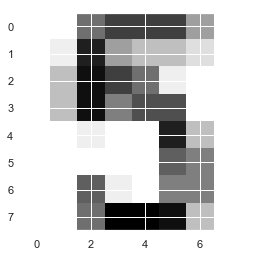

In [2]:
# Load the digits dataset
digits = datasets.load_digits()

# Print the keys and DESCR of the dataset
print(digits.keys())
print(digits.DESCR)

# Print the shape of the images and data keys
print(digits.images.shape)
print(digits.data.shape)

# Display digit 1010
plt.imshow(digits.images[1010], cmap=plt.cm.gray_r, interpolation='nearest')
plt.show()

# k-NN classifier
Digits data was split into training and test sets, and a k-NN classifier from 1 to 9 neighbors was fit to the training data and accuracy characterized for overfitting and underfitting. (Maximum accuracy achieved of 98.6%, with 3 neighbors being optimal)

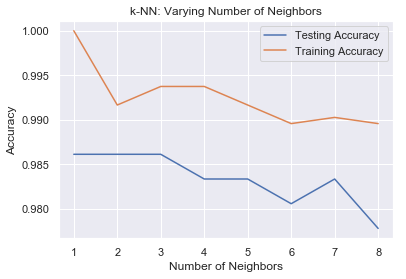

[0.98611111 0.98611111 0.98611111 0.98333333 0.98333333 0.98055556
 0.98333333 0.97777778]


In [3]:
# Create feature and target arrays
X = digits.data
y = digits.target

# Split into training and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

# Setup arrays to store train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k
for i, k in enumerate(neighbors):
    # Setup a k-NN Classifier with k neighbors: knn
    knn = KNeighborsClassifier(n_neighbors=k)

    # Fit the classifier to the training data
    knn.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_train, y_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_test, y_test)

# Generate plot
plt.title('k-NN: Varying Number of Neighbors')
plt.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
plt.plot(neighbors, train_accuracy, label = 'Training Accuracy')
plt.legend()
plt.xlabel('Number of Neighbors')
plt.ylabel('Accuracy')
plt.show()

print(test_accuracy)

# Confusion matrix
k-NN was used to predict digits based on test split, and it appears that 1, 4, 6, 7, 8, and 9 are the digits that the classifier has the most difficulties with.

In [4]:
# Make predictions based on model and calculate confusion matrix
y_pred = knn.predict(X_test)
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[36  0  0  0  0  0  0  0  0  0]
 [ 0 36  0  0  0  0  0  0  0  0]
 [ 0  0 35  0  0  0  0  0  0  0]
 [ 0  0  0 37  0  0  0  0  0  0]
 [ 0  0  0  0 36  0  0  0  0  0]
 [ 0  0  0  0  0 37  0  0  0  0]
 [ 0  1  0  0  0  0 35  0  0  0]
 [ 0  0  0  0  0  0  0 36  0  0]
 [ 0  4  0  0  0  0  0  1 30  0]
 [ 0  0  0  0  1  0  0  0  1 34]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        36
           1       0.88      1.00      0.94        36
           2       1.00      1.00      1.00        35
           3       1.00      1.00      1.00        37
           4       0.97      1.00      0.99        36
           5       1.00      1.00      1.00        37
           6       1.00      0.97      0.99        36
           7       0.97      1.00      0.99        36
           8       0.97      0.86      0.91        35
           9       1.00      0.94      0.97        36

   micro avg       0.98      0.98      0.98       360
   macro avg       

# Hyperparameter tuning

Used grid search and 5-fold cross-validation to determine optimal number of nearest neighbors for classifier. The best score of 98.8% was achieved with 3 neighbors.

In [5]:
# Set up hyperparameter grid
param_grid = {'n_neighbors': np.arange(2, 50)}

# Set up k-NN Classifier
knn = KNeighborsClassifier()

# Use GridSearchCV to fit data
knn_cv = GridSearchCV(knn, param_grid, cv=5)
knn_cv.fit(X_train, y_train)

# Determine the optimal parameters and accuracy
print(knn_cv.best_params_)
print(knn_cv.best_score_)

{'n_neighbors': 3}
0.988169798190675


# Decision tree classifier

Also tried randomized search with a decision tree classifier, which was not able to perform as well as k-NN, with the best score around 78%.

In [6]:
# Set up the parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": randint(1, 9),
              "min_samples_leaf": randint(1, 9),
              "criterion": ["gini", "entropy"]}

# Instantiate a Decision Tree classifier
tree = DecisionTreeClassifier()

# Instantiate the RandomizedSearchCV object
tree_cv = RandomizedSearchCV(tree, param_dist, cv=5)

# Fit it to the data
tree_cv.fit(X_train, y_train)

# Print the tuned parameters and score
print("Tuned Decision Tree Parameters: {}".format(tree_cv.best_params_))
print("Best score is {}".format(tree_cv.best_score_))

Tuned Decision Tree Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 8, 'min_samples_leaf': 1}
Best score is 0.7870563674321504


/Users/wyssuser/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


# SVM Classifier and Pipeline
Created a pipeline to scale the data and perform a grid search for optimal SVM classifier parameters. Optimal cost and gamma were 10 and 0.01, respectively, which was able to achieve an accuracy of 98%, similar to the k-NN classifier.

In [8]:
# Set up the pipeline
steps = [('scaler', StandardScaler()),
         ('SVM', SVC())]
pipeline = Pipeline(steps)

# Specify the hyperparameter space
parameters = {'SVM__C':[1, 10, 100],
              'SVM__gamma':[0.1, 0.01]}

# Create train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

# Instantiate the GridSearchCV object
cv = GridSearchCV(pipeline, parameters, cv=5)

# Fit to the training set
cv.fit(X_train, y_train)

# Predict the labels of the test set
y_pred = cv.predict(X_test)

# Compute and print metrics
print("Accuracy: {}".format(cv.score(X_test, y_test)))
print(classification_report(y_test, y_pred))
print("Tuned Model Parameters: {}".format(cv.best_params_))

Accuracy: 0.9791376912378303
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        67
           1       0.99      0.99      0.99        72
           2       0.97      0.98      0.98        66
           3       0.97      0.97      0.97        71
           4       0.97      0.99      0.98        78
           5       0.99      0.98      0.98        83
           6       0.99      1.00      0.99        69
           7       0.96      0.99      0.97        71
           8       0.98      0.95      0.97        65
           9       0.97      0.95      0.96        77

   micro avg       0.98      0.98      0.98       719
   macro avg       0.98      0.98      0.98       719
weighted avg       0.98      0.98      0.98       719

Tuned Model Parameters: {'SVM__C': 10, 'SVM__gamma': 0.01}


# Neural Network

In [37]:
# Initiate the neural network model
model = Sequential()

# Add the hidden layers
model.add(Dense(1000, activation='relu', input_shape=(64,)))
model.add(Dense(1000, activation='relu', input_shape=(64,)))
model.add(Dense(1000, activation='relu', input_shape=(64,)))

# Add the output layer; 10 for the number of digits
model.add(Dense(10, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Fit the model
y = digits.target
y = to_categorical(y)
model.fit(X, y, validation_split=0.4)

Train on 1078 samples, validate on 719 samples
1078/1078 [==============================] - 1s 520us/sample - loss: 0.8748 - accuracy: 0.7635 - val_loss: 0.3529 - val_accuracy: 0.8999
